In [33]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

## Read the dataset

In [34]:

# Load the data
df = pd.read_csv('GDSI_OpenDataset_Final.csv')

# Function to determine if a column is continuous or discrete
def determine_variable_type(column):
    if pd.api.types.is_numeric_dtype(column):
        unique_values = column.nunique()
        if unique_values > 10:  # Arbitrary threshold to distinguish between continuous and discrete
            return 'Continuous'
        else:
            return 'Discrete'
    else:
        return 'Categorical'

# Initialize a dictionary to store the results
variable_types = {}
missingness_percentages = {}

# Iterate through each column in the DataFrame
for column in df.columns:
    variable_types[column] = determine_variable_type(df[column])
    missingness_percentages[column] = df[column].isnull().mean() * 100

# Convert the results to DataFrames for better visualization
variable_types_df = pd.DataFrame(variable_types.items(), columns=['Variable', 'Type'])
missingness_percentages_df = pd.DataFrame(missingness_percentages.items(), columns=['Variable', 'Missingness (%)'])




In [35]:
variable_types_df

,Variable,Type
0,secret_name,Categorical
1,report_source,Categorical
2,age_in_cat,Discrete
3,bmi_in_cat2,Categorical
4,covid19_admission_hospital,Categorical
5,covid19_confirmed_case,Categorical
6,covid19_diagnosis,Categorical
7,covid19_has_symptoms,Categorical
8,covid19_icu_stay,Categorical
9,covid19_outcome_recovered,Categorical


## Remove the variables with >= 99% of time in one category 

In [36]:
# remove the variables with very limited variability (>99%)
def has_one_level_99_percent(column):
    most_frequent_value_percentage = column.value_counts(normalize=True).max()
    return most_frequent_value_percentage >= 0.99

# Initialize dictionaries to store the results
variable_types = {}
missingness_percentages = {}
columns_to_drop = []

# Iterate through each column in the DataFrame
for column in df.columns:
    variable_types[column] = determine_variable_type(df[column])
    missingness_percentages[column] = df[column].isnull().mean() * 100
    if has_one_level_99_percent(df[column]):
        columns_to_drop.append(column)

# Drop columns that have one level 99% or more of the time
df_cleaned = df.drop(columns=columns_to_drop)
columns_to_drop

['covid19_icu_stay',
 'covid19_ventilation',
 'edss_in_cat2',
 'pregnancy',
 'current_or_former_smoker',
 'comorbidities_other']

In [37]:
from datetime import datetime
df_cleaned['stop_or_end_date_combined'] = pd.to_datetime(df_cleaned['stop_or_end_date_combined'], errors='coerce',format='%d/%m/%Y')

# Extract the year from the date column
df_cleaned['year'] = df_cleaned['stop_or_end_date_combined'].dt.year

# Count the occurrences of each year
year_counts = df_cleaned['year'].value_counts().sort_index()
year_counts/sum(year_counts)


year
1997.0    0.001220
1998.0    0.001220
2003.0    0.001220
2004.0    0.001220
2005.0    0.001220
2006.0    0.001220
2007.0    0.001220
2008.0    0.002439
2009.0    0.001220
2012.0    0.002439
2013.0    0.002439
2014.0    0.003659
2015.0    0.006098
2016.0    0.009756
2017.0    0.012195
2018.0    0.030488
2019.0    0.125610
2020.0    0.795122
Name: count, dtype: float64

Bin the year column to two level 

In [38]:
# if year == 2020 and not NaN, then DMT_year_bin = recent; otherwise, DMT_year_bin = other
df_cleaned['DMT_year_bin'] = np.where((df_cleaned['year'] == 2020), 'recent', np.where(pd.isna(df_cleaned['year']), np.nan, 'other'))

# drop the year column and stop_or_end_date_combined
df_cleaned = df_cleaned.drop(columns=['year', 'stop_or_end_date_combined'])

In [39]:
# set secret_name as the index
df_cleaned = df_cleaned.set_index('secret_name')

explore count table for `year_onset`

<Axes: xlabel='year_onset'>

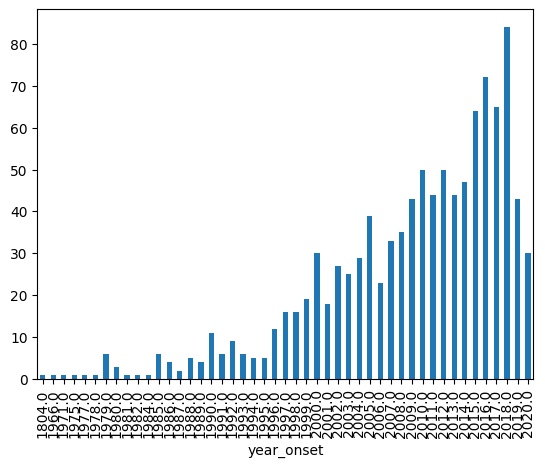

In [40]:
# show count df for `year_onset`
onset_year_counts = df_cleaned['year_onset'].value_counts().sort_index()
# make a bar plot
onset_year_counts.plot(kind='bar')

## Reason to remove year or date variables
The task is to classifying types of MS. Year produced limited information about the disease classicification. In addition, both variable has more data associated with 2020, so it is hard to bin the years without expert knowledge. Including the years as one-hot encoded categories also increase the degree of freedom dramatically. 

In [41]:
# Remove year_onset column and DMT_year_bin
df_cleaned = df_cleaned.drop(columns=['year_onset', 'DMT_year_bin'])

In [42]:
df_cleaned.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1141 entries, C_1005 to P_992
Data columns (total 38 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   report_source                   1141 non-null   object 
 1   age_in_cat                      1141 non-null   int64  
 2   bmi_in_cat2                     890 non-null    object 
 3   covid19_admission_hospital      1141 non-null   object 
 4   covid19_confirmed_case          1141 non-null   object 
 5   covid19_diagnosis               1141 non-null   object 
 6   covid19_has_symptoms            1133 non-null   object 
 7   covid19_outcome_recovered       1141 non-null   object 
 8   covid19_self_isolation          1126 non-null   object 
 9   covid19_sympt_chills            248 non-null    object 
 10  covid19_sympt_dry_cough         281 non-null    object 
 11  covid19_sympt_fatigue           291 non-null    object 
 12  covid19_sympt_fever             2

# remove duplicated has_comorbidities.1 and has_comorbidities.2

In [43]:
## remove duplicated has_comorbidities.1 and has_comorbidities.2
df_cleaned = df_cleaned.drop(columns=['has_comorbidities.1'])
df_cleaned = df_cleaned.drop(columns=['has_comorbidities.2'])

## Show missingness in the `df_cleaned`

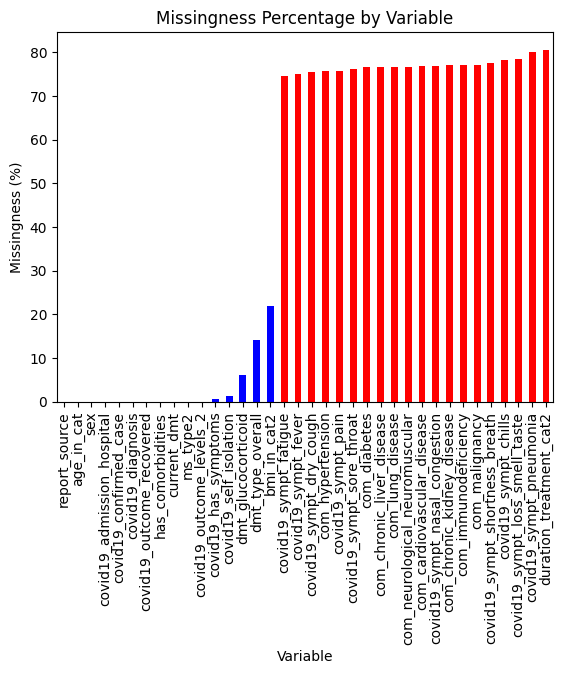

In [44]:
# Sort the values by missingness percentage
missingness_percentages_df = missingness_percentages_df[missingness_percentages_df['Variable'].isin(df_cleaned.columns)]
missingness_percentages_df = missingness_percentages_df.sort_values(by='Missingness (%)')

# Create a list of colors based on the condition
colors = ['red' if pct > 70 else 'blue' for pct in missingness_percentages_df['Missingness (%)']]

# Plot the bar plot with conditional coloring
ax = missingness_percentages_df.plot(kind='bar', x='Variable', y='Missingness (%)', color=colors, legend=False)

# Set plot labels and title
ax.set_ylabel('Missingness (%)')
ax.set_title('Missingness Percentage by Variable')

# Display the plot
plt.show()

## Show outcome variable's distribution in three classes

Text(0.5, 1.0, 'Counts of class distribution for ms_type2')

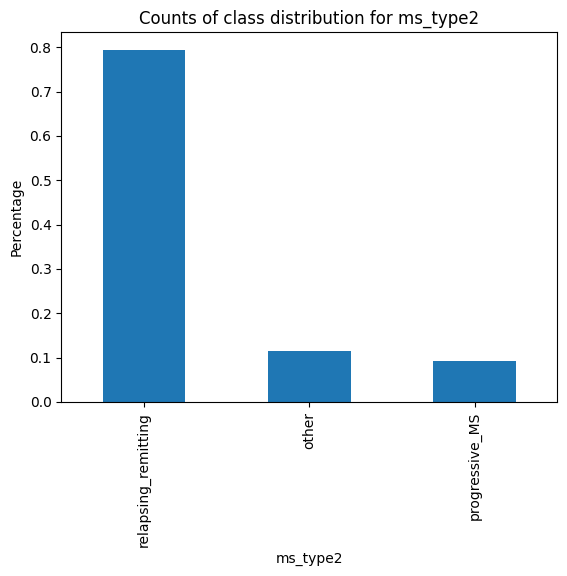

In [45]:
## plot for ms_type2 
ms_type2_counts = df_cleaned['ms_type2'].value_counts() / len(df_cleaned)
ax = ms_type2_counts.plot(kind='bar')

# set labels
ax.set_xlabel('ms_type2')
ax.set_ylabel('Percentage')
ax.set_title('Counts of class distribution for ms_type2')

### one-hot encode the `df_cleaned` with NAN value being assigned to another level

In [46]:
# Deal with int64 and float64 variables
df_cleaned['age_in_cat'] = df_cleaned['age_in_cat'].astype('category')
df_cleaned['covid19_outcome_levels_2'] = df_cleaned['covid19_outcome_levels_2'].astype('category')
df_cleaned['duration_treatment_cat2'] = df_cleaned['duration_treatment_cat2'].astype('category')

# Identify columns with NaN values
columns_with_na = df_cleaned.columns[df_cleaned.isnull().any()]

# Apply pd.get_dummies() with dummy_na=True to columns with NaN values
df_with_na_dummies = pd.get_dummies(df_cleaned[columns_with_na], dummy_na=True)

# Apply pd.get_dummies() without dummy_na to the rest of the columns
df_without_na_dummies = pd.get_dummies(df_cleaned.drop(columns_with_na, axis=1))

# Concatenate the results
df_cleaned_OH = pd.concat([df_with_na_dummies, df_without_na_dummies], axis=1)
df_cleaned_OH = df_cleaned_OH.astype(int)
# Display the info of the one-hot encoded DataFrame
print(df_cleaned_OH.info())

<class 'pandas.core.frame.DataFrame'>
Index: 1141 entries, C_1005 to P_992
Columns: 112 entries, bmi_in_cat2_not_overweight to covid19_outcome_levels_2_2
dtypes: int32(112)
memory usage: 508.1+ KB
None


In [47]:
# save it to a csv file
df_cleaned_OH.to_csv('GDSI_OpenDataset_Final_cleaned_OH.csv')

## Try to impute variables with reasonable missingness (< 70%)

In [48]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from sklearn.impute import KNNImputer

# Assume df_cleaned is your original DataFrame
# Define the columns to be imputed
variables_to_impute = ['bmi_in_cat2', 'dmt_glucocorticoid', 'dmt_type_overall', 'covid19_has_symptoms', 'covid19_self_isolation']

# Step 1: Encode all columns using LabelEncoder
label_encoders = {}
df_encoded = df_cleaned.copy()

for col in df_encoded.columns:
    le = LabelEncoder()
    # Fit the encoder only on non-null values
    non_null_values = df_encoded[col].dropna()
    le.fit(non_null_values)
    df_encoded[col] = df_encoded[col].apply(lambda x: le.transform([x])[0] if pd.notna(x) else np.nan)
    label_encoders[col] = le

# Step 2: Apply KNNImputer to the entire dataset
imputer = KNNImputer(n_neighbors=3, weights='distance')
df_imputed = pd.DataFrame(imputer.fit_transform(df_encoded), columns=df_encoded.columns)

# Step 3: Round the imputed values and convert them to integers
df_imputed = df_imputed.round().astype(int)

# Step 4: Decode the imputed values back to their original string format
for col in variables_to_impute:
    le = label_encoders[col]
    df_imputed[col] = df_imputed[col].apply(lambda x: le.inverse_transform([int(x)])[0] if pd.notna(x) else np.nan)

# # Replace only the imputed columns in the original DataFrame
# df_cleaned.loc[:, variables_to_impute] = df_imputed[variables_to_impute]

# # Now df_cleaned contains the original data with the specified columns imputed
# print(df_cleaned[variables_to_impute].head())


In [49]:
# Verify the imputed values in df_imputed_final
print("df_imputed_final verification (before assignment):")
print(df_imputed[variables_to_impute].head())

# Step 5: Create a new DataFrame to combine original data with imputed values
df_combined = df_cleaned.copy()

# Explicitly assign each column's imputed values to the corresponding column in df_combined
for col in variables_to_impute:
    df_combined[col] = df_imputed[col].values

# Now df_combined contains the original data with the specified columns imputed
print("df_combined after assignment:")
print(df_combined[variables_to_impute].head())


df_imputed_final verification (before assignment):
      bmi_in_cat2 dmt_glucocorticoid                      dmt_type_overall  \
0      overweight                 no               currently on fingolimod   
1  not_overweight                 no              currently on natalizumab   
2  not_overweight                 no               currently on fingolimod   
3  not_overweight                 no  currently on another drug not listed   
4  not_overweight                 no  currently on another drug not listed   

  covid19_has_symptoms covid19_self_isolation  
0                  yes                    yes  
1                  yes                    yes  
2                  yes                    yes  
3                  yes                    yes  
4                  yes                    yes  
df_combined after assignment:
                bmi_in_cat2 dmt_glucocorticoid  \
secret_name                                      
C_1005           overweight                 no   
C_1008      

In [50]:
# Step 1: Identify columns with NaN values in df_combined
columns_with_na = df_combined.columns[df_combined.isnull().any()]

# Step 2: Apply pd.get_dummies() with dummy_na=True to columns with NaN values
df_with_na_dummies = pd.get_dummies(df_combined[columns_with_na], dummy_na=True)

# Step 3: Apply pd.get_dummies() without dummy_na to the rest of the columns
df_without_na_dummies = pd.get_dummies(df_combined.drop(columns_with_na, axis=1))

# Step 4: Concatenate the results
df_combined_OH = pd.concat([df_with_na_dummies, df_without_na_dummies], axis=1)

# Step 5: Convert the one-hot encoded DataFrame to integers
df_combined_OH = df_combined_OH.astype(int)

# Display the info of the one-hot encoded DataFrame
print(df_combined_OH.info())


<class 'pandas.core.frame.DataFrame'>
Index: 1141 entries, C_1005 to P_992
Columns: 107 entries, covid19_sympt_chills_no to covid19_outcome_levels_2_2
dtypes: int32(107)
memory usage: 518.1+ KB
None


In [51]:
# save it to a csv file
df_combined_OH.to_csv('GDSI_OpenDataset_Final_cleaned_OH_imputed.csv')

## look at some comorb

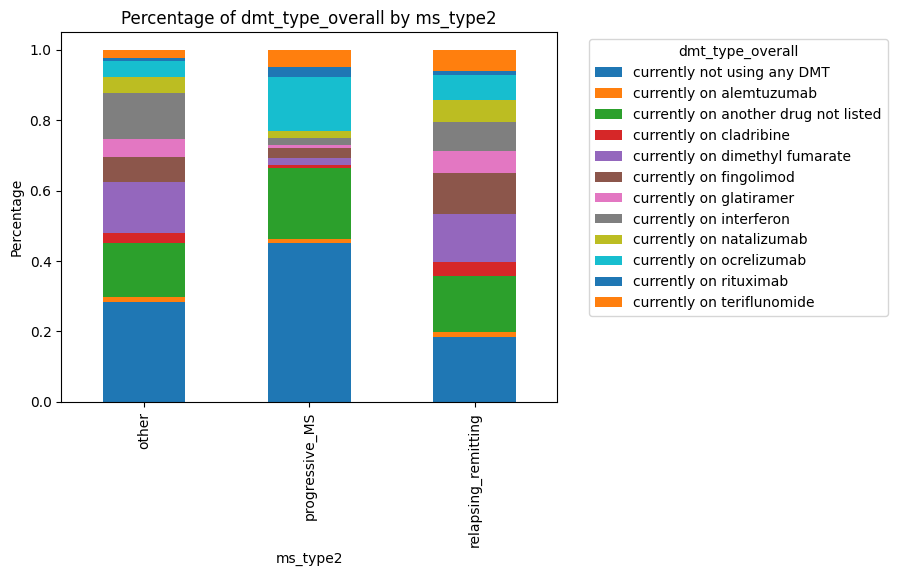

In [25]:
# count the percentage of `dmt_type_overall` for each class in `ms_type2`
# Calculate the percentage of each class in `ms_type2`
ms_type2_counts = df_combined['ms_type2'].value_counts(normalize=True)

# Group by `ms_type2` and `dmt_type_overall`, then calculate the percentage of each class
grouped = df_combined.groupby(['ms_type2', 'dmt_type_overall']).size().unstack()
grouped = grouped.div(grouped.sum(axis=1), axis=0)

# Plot the grouped DataFrame
grouped.plot(kind='bar', stacked=True)

# Set plot labels and title
plt.xlabel('ms_type2')
plt.ylabel('Percentage')
plt.title('Percentage of dmt_type_overall by ms_type2')

# move legend outside of the plot
plt.legend(title='dmt_type_overall', bbox_to_anchor=(1.05, 1), loc='upper left')

# Display the plot
plt.show()

In [28]:
# get has_comorbidity has_comorbidity.1 and has_comorbidity.2
# Combine the three columns into a single column
comorb = df_cleaned[['has_comorbidities', 'has_comorbidities.1', 'has_comorbidities.2']]

# check if they are all the same
all_same = comorb.nunique(axis=1) == 1



In [29]:
all_same.value_counts(normalize=True)

True    1.0
Name: proportion, dtype: float64